## MACs and Memory Usage

### FLOPs and MACs

FLOPs (Floating Point Operations) and MACs (Multiply-Accumulate Operations) are metrics that are commonly used to calculate the computation complexity of deep leaerning model. 

FLOPs specifically refer to the number of floating-point operations, which include addition, subtraction, multiplication, and division operations on floating-point numbers. FLOPs are often used to measure the computational cost or complexity of a modle or a specific operation within a model. 

MACs, on the other hand, only count the number of muliply-accumulate operations, which involve multiplying two numbers and adding the result. MACs are often used as a more specific measure of computational complexity in models that heavily rely on linear algebra operations, such as convolutional neural networks (CNNs).

Example FLOPs:

* The Input Image is of size 28x28x1 (grayscale)
* run 2 Convolutions of 5 kernels of size (3x3)
* run a Fully Connected Layer of 128 Neurons
* finish with a Fully Connected Layer of 10 Neurons: 1 per digit.
<img src="./rsc/flops1.png" width="600" height="800">

Calculate the FLOPs:

* Convolutions - FLOPs = 2x Number of Kernel x Kernel Shape x Output Shape
* Fully Connected Layers - FLOPs = 2x Input Size x Output Size

  This counts each multiplications and addtions separately, hence the factor of 2.

    * First Convolution - 2x5x(3x3)x26x26 = 60,840 FLOPs
    * Second Convolution -2x5x(3x3x5)x24x24 = 259,200 FLOPs
    * First FC Layer - 2x(24x24x5)x128 = 737,280 FLOPs
    * Second FC Layer - 2x128x10 = 2,560 FLOPs


<img src="./rsc/flops2.png" width="600" height="800">

**As a rule of thumb**
$$\text{1 MACs} \approx \text{2 FLOPs}$$

* 1 MAC includes:
    
    * 1 multiplication (1 FLOP)
    * 1 addition (1 FLOP)

-> $1\text{ MAC} = 1 \text{ multiplication} + 1 \text{ addition} = 2 \text{ FLOPs}$

Images from [How to Optimize a Deep Learning Model for faster Inference?](https://www.thinkautonomous.ai/blog/deep-learning-optimization/)

In [3]:
def calc_output_shape(layer, input_shape):
    input=torch.randn(input_shape)
    output = layer(input)
    return tuple(output.shape)
    
def calc_macs_conv2d(layer, input_shape):
    b, in_ch, in_h, in_w = input_shape
    out_ch, _, f_h, f_w = layer.weight.shape

    _,_, out_h, out_w = calc_output_shape(layer, input_shape)

    macs = in_ch * out_ch * f_h * f_w * out_h * out_w

    return macs

def calc_macs_linear(layer, input_shape):
    b, in_features = input_shape
    out_features, _ = layer.weight.shape

    macs = b * in_features * out_features

    return macs

In [4]:
import torch
from torch import nn

In [5]:
input_shape = (1, 1, 128, 128)
X = torch.randn(input_shape)
layer = nn.Conv2d(1,8,kernel_size=3)
output = layer(X)
output.shape

torch.Size([1, 8, 126, 126])

In [6]:
input_shape = (1, 1, 28, 28)
X = torch.randn(input_shape)
layer = nn.Conv2d(1,5,kernel_size=3)
output = layer(X)
output.shape

torch.Size([1, 5, 26, 26])

In [7]:
calc_macs_conv2d(layer, input_shape)

30420

In [8]:
linear_layer = nn.Linear(64,10)
input_shape = (1, 64)
calc_macs_linear(linear_layer, input_shape)

640

### thop.profile()
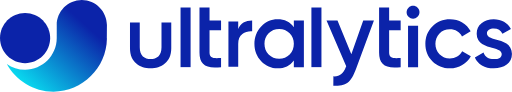
> Welcome to the THOP repository, your comprehensive solution for profiling PyTorch models by computing the number of Multiply-Accumulate Operations (MACs) and parameters. This tool is essential for deep learning practitioners to evaluate model efficiency and performance.

Installation:
```python
pip install ultralytics-thop
```

[THOP: PyTorch-OpCounter](https://github.com/ultralytics/thop)

In [9]:
import thop

In [10]:
macs, params = thop.profile(layer, (X,))
macs

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.


30420.0

In [13]:
linear_layer = nn.Linear(64,10)
input_shape = (1, 64)
X = torch.randn(input_shape)
macs, params = thop.profile(linear_layer, (X,))
macs

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


640.0

### Memory Usage

Major memory usage:
1. Model parameters
2. Layer outputs
3. Optimizer parameters:
    * Adam: 1st order moment, 2nd order moment etc